# Diversity



---

Load up a tonne of libraries

In [1]:
import datetime
import json
import os
import pickle
import random
import re
import textwrap
from pathlib import Path
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull

import message_helpers as mh
from hangouts_loader import load_hangouts


In [2]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["font.sans-serif"] = ["Segoe UI Emoji"]


In [3]:
pickle_name = "all_convo.pickle"
pickle_path = Path(pickle_name)


Set your name here. This is so that you can take yourself out of some of the graphs. Because these are conversations, naievely, they go A B A B and so on, so you'll be roughly 50% of the messages, which makes other trends hard to see.

In [4]:
MY_NAME = "Ben Doherty"


In [5]:
all_convo_df = pd.read_pickle(pickle_path)
print(f"done: all_convo_df has {all_convo_df.shape[0]} rows")
all_convo_df = all_convo_df.set_index("datetime").sort_index()
all_convo_df.head()


done: all_convo_df has 1011154 rows


,sender_name,timestamp_ms,content,type,is_unsent,users,source_convo,message_length,platform,photos,...,ip,gifs,files,audio_files,missed,event_id,input_names,initials,gender,clean_content
datetime,,,,,,,,,,,,,,,,,,,,,
2007-01-07 08:53:44,Charles Ogilvie,1.168120e+12,"i have no bike in oxford,\nor id be out there ...",Generic,False,NaN,thearlaichogilive_hfdurrqsxq,111,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Thearlaich Ogilive,CO,m,bike oxford id well wouldnt im london coming o...
2007-01-07 10:46:36,Ben Doherty,1.168127e+12,"well i'm in the london, so i have no bike in o...",Generic,False,NaN,thearlaichogilive_hfdurrqsxq,119,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Ben Doherty,BD,me,well london bike oxford either sitting anti so...
2007-01-07 11:30:42,Charles Ogilvie,1.168130e+12,are you a fully qualified architecturdburglar ...,Generic,False,NaN,thearlaichogilive_hfdurrqsxq,73,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Thearlaich Ogilive,CO,m,fully qualified architecturdburglar happened anna
2007-01-07 12:36:24,Ben Doherty,1.168134e+12,i'm doing a masturbate at UEL in programmer ty...,Generic,False,NaN,thearlaichogilive_hfdurrqsxq,224,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Ben Doherty,BD,me,masturbate uel programmer type stuff anna stil...
2007-01-10 11:08:36,Ben Doherty,1.168388e+12,"sweet, i'm right on it\n\nhttp://whytheluckyst...",Generic,False,NaN,thearlaichogilive_hfdurrqsxq,80,Facebook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Ben Doherty,BD,me,sweet right whytheluckystiff net saw though


In [6]:
print(
    f"Overall, there are {len(all_convo_df)}, messages in this dataset. "
    f"These come from about {len(all_convo_df.sender_name.unique())} people, "
    f"covering a period of {str(all_convo_df.index.max()-all_convo_df.index.min()).split(' days')[0]} days "
    f"between {all_convo_df.index.min():%B, %Y} and {all_convo_df.index.max():%B, %Y}. "
    f"Over {len(all_convo_df.platform.unique())} platforms:"
)
all_convo_df.platform.value_counts()


Overall, there are 1011154, messages in this dataset. These come from about 773 people, covering a period of 5473 days between January, 2007 and January, 2022. Over 3 platforms:


Facebook     764999
Hangouts     146211
Instagram     99944
Name: platform, dtype: int64

# How many people do I talk to in a given period? 

When was I obsessive, when was I broad, when was I mist chatty?

Text(0.5, 1.0, 'Number of people chatted with in different time windows')

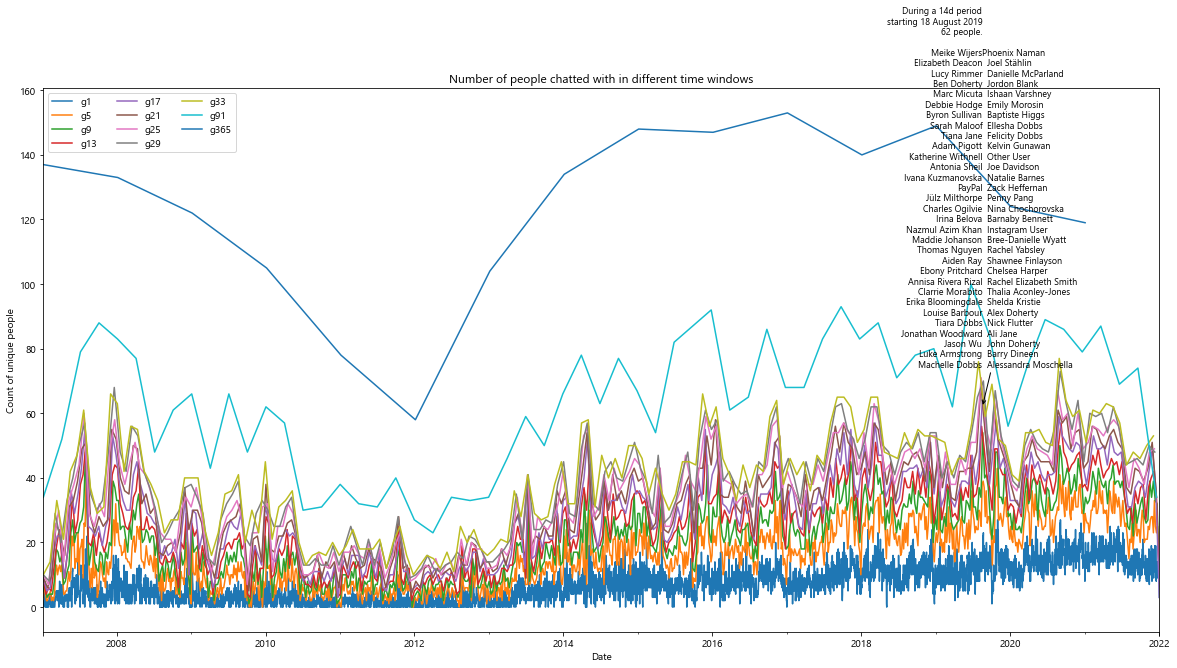

In [121]:
def count_people(d):
    return len(d.sender_name.unique())


for n in list(range(1, 35, 4)) + [91, 365]:
    x = all_convo_df.groupby(pd.Grouper(freq=f"{n}d")).apply(count_people)
    x.plot(label=f"g{n}")

freq = "14d"
quarterly_groups = all_convo_df.groupby(pd.Grouper(freq=freq))
quarterly = quarterly_groups.apply(count_people)
u_names = quarterly_groups.get_group(quarterly.idxmax()).sender_name.unique()
d = f'During a {freq} period\nstarting {quarterly.idxmax().strftime("%d %B %Y")}\n{len(u_names)} people.\n'
font_size = 9
plt.annotate(
    d + "\n" + "\n".join(u_names[: int(len(u_names) / 2)]),
    (quarterly.idxmax(), quarterly.max()),
    fontsize=font_size,
    horizontalalignment="right",
    xycoords="data",
    xytext=(0, 40),
    textcoords="offset points",
)
plt.annotate(
    "\n  ".join(u_names[int(len(u_names) / 2) :]),
    (quarterly.idxmax(), quarterly.max()),
    fontsize=font_size,
    horizontalalignment="left",
    xycoords="data",
    xytext=(0, 40),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
)
# plt.xlim(["2019-08-01","2019-10-01"])
plt.legend(ncol=3, loc="upper left")
plt.ylabel("Count of unique people")
plt.xlabel("Date")
plt.title("Number of people chatted with in different time windows")
